In [1]:
import numpy as np
import pandas as pd
# from sklearn.preprocessing import
from sklearn.model_selection import train_test_split
from random import randint
import sklearn.metrics as skm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [2]:
def replace_rare_entries(df, columns, threshold_frac):
    tot_instances = df.shape[0]
    threshold = tot_instances * threshold_frac
    df = df.apply(lambda x: x.mask(x.map(x.value_counts()) < threshold, 'RARE') if x.name in columns else x)
    return df
    

In [3]:
categoricals = ['OP_UNIQUE_CARRIER', 'DEST', 'DEP_TIME_BLK', 'DAY_OF_YEAR', 'DAY_OF_WEEK']
targets = ['DEP_DELAY_NEW', 'DEP_DEL15']

In [4]:
df = pd.read_csv('/home/dbeiski/Project/FlightDelay/Data/new_york/year_lga_dep.csv')

In [5]:
data = df.drop([col for col in df.columns if col not in categoricals], axis=1)
data = replace_rare_entries(data, ['DEST'], 0.005)
data = replace_rare_entries(data, ['UNIQUE_CARRIER'], 0.005)
data = pd.get_dummies(data, columns=categoricals)
label = df['DEP_DEL15']

In [6]:
data.columns

Index(['OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_B6',
       'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9',
       'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OH',
       'OP_UNIQUE_CARRIER_OO',
       ...
       'DAY_OF_YEAR_9_7', 'DAY_OF_YEAR_9_8', 'DAY_OF_YEAR_9_9',
       'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7'],
      dtype='object', length=457)

In [7]:
data = data[~label.isna()]
label = label[~label.isna()]

In [8]:
print('Rows: {}\nFeatures: {}\nLabel-1 Fraction: {}'
      .format(data.shape[0], data.shape[1], label.sum() / label.shape[0]))

Rows: 181088
Features: 457
Label-1 Fraction: 0.21473537727513695


In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2,
                                                        random_state=randint(1, 500),
                                                        stratify=label)
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
arg = (y_test, xgbc.predict(x_test))
print('Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'.format(skm.accuracy_score(*arg), skm.recall_score(*arg), skm.precision_score(*arg), skm.f1_score(*arg)))

Accuracy: 0.7943011762107239
Recall: 0.049376366208049374
Precision: 0.8707482993197279
f1_Score: 0.09345339498661474


In [11]:
probas = xgbc.predict_proba(x_test)[:, 1]

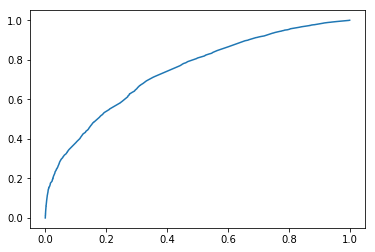

In [12]:
tpr, fpr, thres = roc_curve(y_test, probas)
plt.plot(tpr, fpr);

In [13]:
thres = np.linspace(0, 1, 500)

In [14]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


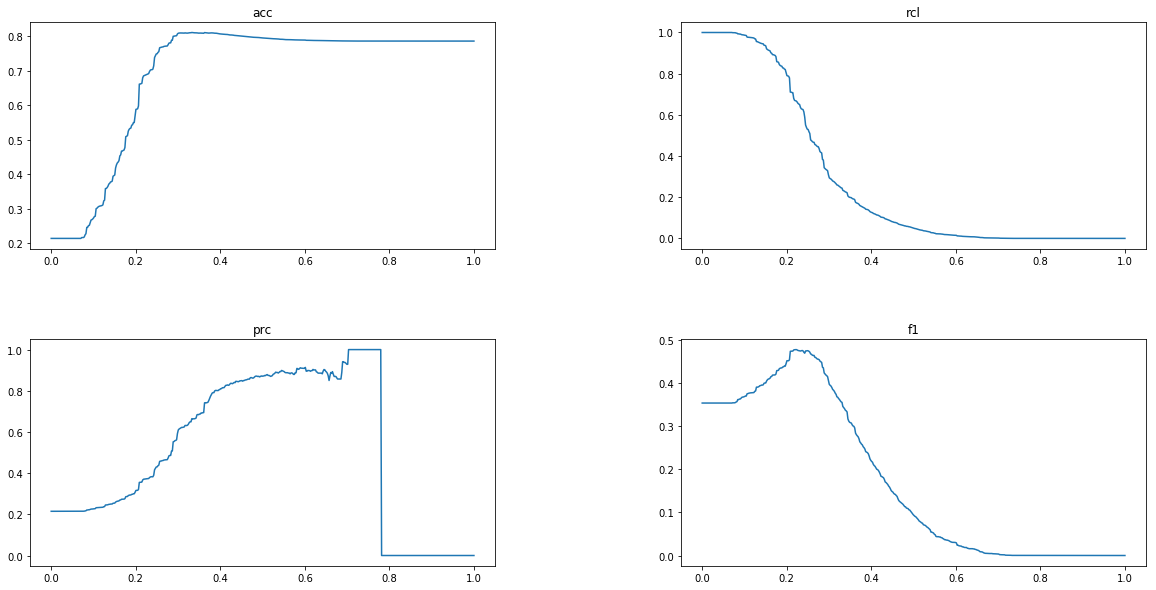

In [15]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


In [16]:
best_thres = thres[np.argmax(f1s)]
y_pred = (probas > best_thres).astype(int)
print(skm.accuracy_score(y_test, y_pred))

0.6864266386879452


In [17]:
best_thres

0.2224448897795591

In [22]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=y)
Dtrain = xgb.DMatrix(x_train, label=y_train)
Dval = xgb.DMatrix(x_val, label=y_val)

/home/dbeiski/PycharmProjects/fl5/linear_models/venv3.5/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [29]:
y_train.shape[0]

115896

In [39]:
param = {                              # General guidelines for initial paramaters:
    'min_child_weight': 1,             # 1 (choose small for high class imbalance)
    'gamma': 0.5,                        # 0.1-0.2
    'lambda': 10,                       # L2 Regulariztion - default = 1
    'scale_pos_weight': 4,             # 1 (choose small for high class imbalance)
    'subsample': 0.6,                    # 0.5-0.9
    'colsample_bytree': 0.8,             # 0.5-0.9
    'colsample_bylevel': 0.7,              # 0.5-0.9
    'max_depth': 5,                    # 3-10 
    'eta': 0.1,                        # 0.05-0.3
    'silent': 0,                       # 0 - prints progress    1 - quiet
    'objective': 'binary:logistic',        
    'num_class': 1,             
    'eval_metric': 'auc'}  
num_round = 1000                                      # the number of training iterations if not stopped early
evallist = [(Dtrain, 'train'), (Dval, 'eval')]        # Specify validation set to watch performance

In [40]:
# Train the model on the training set to get an initial impression on the performance
model = xgb.train(param, Dtrain, num_round, evallist, early_stopping_rounds=10)
print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.601932	eval-auc:0.602806
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.634049	eval-auc:0.635827
[2]	train-auc:0.656239	eval-auc:0.659068
[3]	train-auc:0.656832	eval-auc:0.659425
[4]	train-auc:0.660613	eval-auc:0.662581
[5]	train-auc:0.66197	eval-auc:0.664425
[6]	train-auc:0.671242	eval-auc:0.67178
[7]	train-auc:0.680003	eval-auc:0.679312
[8]	train-auc:0.681438	eval-auc:0.681075
[9]	train-auc:0.680711	eval-auc:0.680393
[10]	train-auc:0.68299	eval-auc:0.681935
[11]	train-auc:0.688903	eval-auc:0.686586
[12]	train-auc:0.689376	eval-auc:0.687054
[13]	train-auc:0.694727	eval-auc:0.692649
[14]	train-auc:0.695492	eval-auc:0.693152
[15]	train-auc:0.698443	eval-auc:0.696253
[16]	train-auc:0.701631	eval-auc:0.69888
[17]	train-auc:0.703765	eval-auc:0.700541
[18]	train-auc:0.704031	eval-auc:0.700945
[19]	train-auc:0.704524	eval-auc:0.701761
[20]	train-auc:0.706103	eval-auc:

[191]	train-auc:0.779469	eval-auc:0.773697
[192]	train-auc:0.779571	eval-auc:0.773782
[193]	train-auc:0.779417	eval-auc:0.773641
[194]	train-auc:0.779594	eval-auc:0.77384
[195]	train-auc:0.779785	eval-auc:0.773989
[196]	train-auc:0.780066	eval-auc:0.774228
[197]	train-auc:0.780178	eval-auc:0.774296
[198]	train-auc:0.780317	eval-auc:0.774455
[199]	train-auc:0.780443	eval-auc:0.774584
[200]	train-auc:0.780649	eval-auc:0.774812
[201]	train-auc:0.78083	eval-auc:0.77499
[202]	train-auc:0.781003	eval-auc:0.775086
[203]	train-auc:0.781103	eval-auc:0.77524
[204]	train-auc:0.781247	eval-auc:0.775386
[205]	train-auc:0.781575	eval-auc:0.775784
[206]	train-auc:0.781755	eval-auc:0.775894
[207]	train-auc:0.781896	eval-auc:0.776051
[208]	train-auc:0.782103	eval-auc:0.776231
[209]	train-auc:0.782261	eval-auc:0.776383
[210]	train-auc:0.782307	eval-auc:0.776498
[211]	train-auc:0.782453	eval-auc:0.776589
[212]	train-auc:0.782559	eval-auc:0.776685
[213]	train-auc:0.782832	eval-auc:0.776834
[214]	train-auc

[383]	train-auc:0.80145	eval-auc:0.790117
[384]	train-auc:0.801497	eval-auc:0.790186
[385]	train-auc:0.801539	eval-auc:0.790229
[386]	train-auc:0.801613	eval-auc:0.790281
[387]	train-auc:0.8017	eval-auc:0.790362
[388]	train-auc:0.801768	eval-auc:0.790428
[389]	train-auc:0.801808	eval-auc:0.790471
[390]	train-auc:0.80193	eval-auc:0.790506
[391]	train-auc:0.801973	eval-auc:0.79055
[392]	train-auc:0.80202	eval-auc:0.790542
[393]	train-auc:0.802068	eval-auc:0.790613
[394]	train-auc:0.802129	eval-auc:0.790595
[395]	train-auc:0.802227	eval-auc:0.790683
[396]	train-auc:0.80232	eval-auc:0.790699
[397]	train-auc:0.802412	eval-auc:0.790776
[398]	train-auc:0.802475	eval-auc:0.790807
[399]	train-auc:0.802522	eval-auc:0.790802
[400]	train-auc:0.802557	eval-auc:0.790834
[401]	train-auc:0.802568	eval-auc:0.790806
[402]	train-auc:0.802624	eval-auc:0.790783
[403]	train-auc:0.802674	eval-auc:0.790753
[404]	train-auc:0.802695	eval-auc:0.790776
[405]	train-auc:0.802738	eval-auc:0.790831
[406]	train-auc:0.

In [46]:
Dtest = xgb.DMatrix(x_test)
y_pred = model.predict(Dtest)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_names'

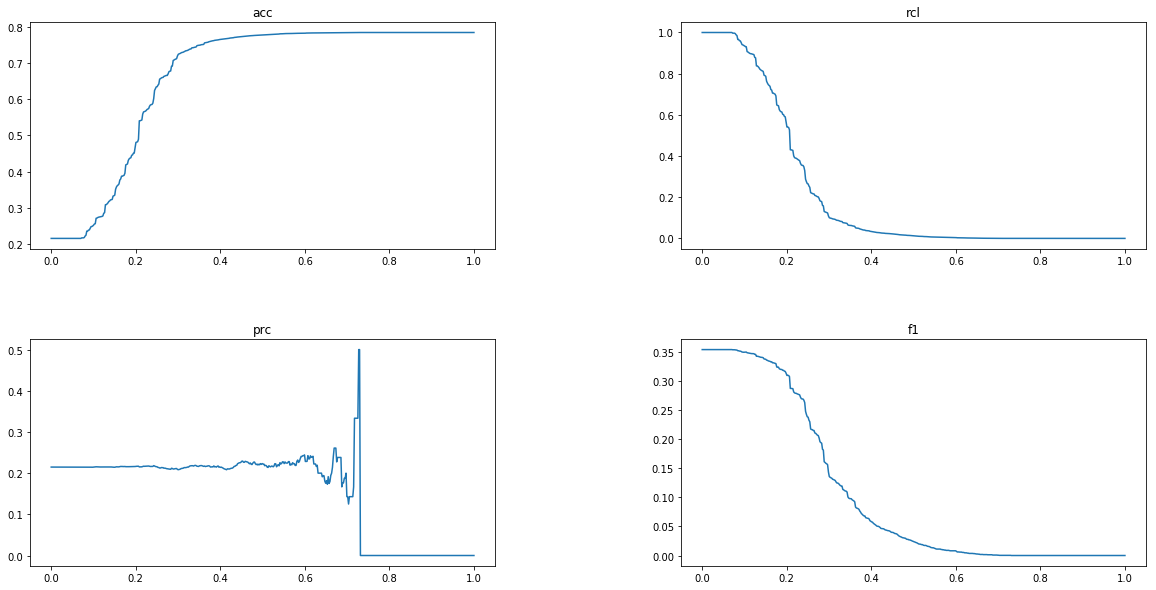

In [42]:
accs, recalls, precs, f1s = [], [], [], []
for thr in thres:
    y_pred = (probas > thr).astype(int)
    accs.append(skm.accuracy_score(y_test, y_pred))
    recalls.append(skm.recall_score(y_test, y_pred))
    precs.append(skm.precision_score(y_test, y_pred))
    f1s.append(skm.f1_score(y_test, y_pred))
    
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, (metric, name) in enumerate(zip([accs, recalls, precs, f1s], ['acc', 'rcl', 'prc', 'f1']), start=1):
    fig.add_subplot(2, 2, i)
    plt.plot(thres, metric)
    plt.title(name)


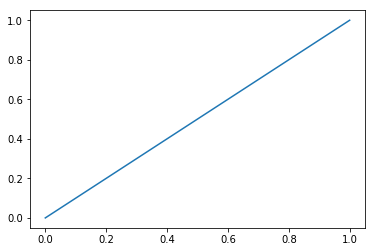

In [43]:
tpr, fpr, _ = roc_curve(y_test, y_pred)
plt.plot(tpr, fpr);

In [69]:
xgbc = XGBClassifier()
accs, recalls, precs, f1s = [], [], [], []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, 
                                                        random_state=randint(1, 500),
                                                        stratify=label)
    xgbc.fit(x_train, y_train)
    arg = (y_test, xgbc.predict(x_test))
    accs.append(skm.accuracy_score(*arg))
    recalls.append(skm.recall_score(*arg))
    precs.append(skm.precision_score(*arg))
    f1s.append(skm.f1_score(*arg))
    print('{} - Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'
      .format(i, accs[-1], recalls[-1], precs[-1], f1s[-1]))
print('Avg: Accuracy: {}\nRecall: {}\nPrecision: {}\nf1_Score: {}'
      .format(np.mean(accs), np.mean(recalls), np.mean(precs), np.mean(f1s)))
    
    

0 - Accuracy: 0.7946877243359656
Recall: 0.05091283106196966
Precision: 0.88
f1_Score: 0.0962566844919786
1 - Accuracy: 0.7950190513004584
Recall: 0.054512728207765496
Precision: 0.8582995951417004
f1_Score: 0.10251450676982592
2 - Accuracy: 0.7939698492462312
Recall: 0.04885574697865775
Precision: 0.8558558558558559
f1_Score: 0.09243493067380198
3 - Accuracy: 0.794577282014468
Recall: 0.05065569555155567
Precision: 0.8755555555555555
f1_Score: 0.09577053962080699
4 - Accuracy: 0.7946325031752167
Recall: 0.05348418616610954
Precision: 0.8455284552845529
f1_Score: 0.10060459492140267
5 - Accuracy: 0.7952399359434535
Recall: 0.0542555926973515
Precision: 0.8755186721991701
f1_Score: 0.10217917675544795


KeyboardInterrupt: 